# Proyecto 13 — Etapa 2 (Hito Intermedio)




## 1. Preparación del entorno
En esta sección configuramos el entorno de trabajo para importar el paquete `src` desde la raíz del proyecto y verificamos que PyTorch y CUDA estén disponibles en el kernel seleccionado.


In [33]:
# --- 1.1 Importaciones y ruta al paquete `src` ---
import sys
from pathlib import Path

CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

# Importar utilidades del paquete src
from src.infer import load_model, compute_logits
from src.metrics import entropy_from_logits, surprisal_of_true_token
print("Imports OK")


PROJECT_ROOT: C:\Users\verga\Documents\U\10mo\teoria\Proyecto
Imports OK


In [34]:
# --- 1.2 Verificación de PyTorch/CUDA y versiones ---
import sys, torch
try:
    import transformers
    hf_ver = transformers.__version__
except Exception:
    hf_ver = "N/A"

print("Python exe:", sys.executable)
print("torch:", torch.__version__, "| cuda runtime:", getattr(torch.version, "cuda", None))
print("CUDA disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("transformers:", hf_ver)


Python exe: c:\Users\verga\Documents\U\10mo\teoria\Proyecto\.venv\Scripts\python.exe
torch: 2.6.0+cu124 | cuda runtime: 12.4
CUDA disponible: True
Dispositivo: NVIDIA GeForce RTX 4060 Ti
transformers: 4.44.2


## 2. Objetivo y alcance del hito

El objetivo de este **Hito Intermedio** es escalar el análisis desarrollado en la etapa anterior a un conjunto más amplio de textos y comparar el comportamiento de distintos modelos de lenguaje en términos de *incertidumbre* y *sorpresa* (entropía y surprisal).

El propósito es evaluar **si los modelos mantienen consistencia y estabilidad** en sus predicciones al variar el dominio, la longitud y la estructura sintáctica de los textos.

---

### 2.1 Preguntas de análisis

- ¿Qué modelo presenta una menor entropía promedio (mayor capacidad de anticipación)?  
- ¿Existen diferencias significativas en la distribución del surprisal entre los modelos comparados?  
- ¿Cómo varía la incertidumbre a medida que las frases se vuelven más complejas o abstractas?  
- ¿La correlación entre entropía y surprisal se mantiene estable entre modelos y tipos de texto?

---

### 2.2 Criterios de éxito y supuestos

- Se debe obtener un **DataFrame consolidado** con métricas por token para cada modelo y texto.  
- Los resultados deben incluir **promedios y desviaciones estándar** de entropía y surprisal por texto y por modelo.  
- Se deben generar **visualizaciones comparativas** (líneas, dispersión y boxplots) que permitan interpretar diferencias entre modelos.  
- El código debe ser **reproducible y escalable**, con soporte para GPU y posibilidad de añadir más textos sin modificar la estructura base.  
- Los modelos a comparar se ejecutarán bajo las mismas condiciones (tamaño de batch, longitud máxima y base logarítmica).

---

> Este hito se centra en el **análisis cuantitativo y comparativo**; la interpretación semántica y visualización avanzada se desarrollarán en el Hito Final.


## 3. Decisiones metodológicas

Esta sección fija cómo vamos a correr los modelos y calcular métricas:

### 3.1 Modelos a comparar
- Por defecto: **`gpt2`** y **`distilgpt2`** (ligero, útil como baseline).
- Se pueden añadir otros modelos compatibles con `AutoTokenizer`/`AutoModelForCausalLM`.

### 3.2 Parámetros globales
- **MAX_LEN** = 256 (truncamos entradas largas para mantener tiempos razonables).
- **Base log** = 2 → reportamos **bits**.
- **fp16** en GPU cuando sea posible (ahorra VRAM, acelera).  
- **Batch**: usamos el batch implícito por lista de textos (no muestreamos, solo inferencia).

### 3.3 Definiciones de métricas
- **Entropía** (por paso):  
  $ H(p) = -\sum_i p_i \log_2 p_i $ sobre la distribución del siguiente token.
- **Surprisal** del token observado $t$:  
  $-\log_2 p(t)$.  
- **Alineación temporal**: para una secuencia de tokens $[x_0,\dots,x_T]$, medimos:
  - Entropía en pasos $0..T-1$ (predice $x_{k+1}$).
  - Surprisal usando el **token verdadero desplazado** $x_{1..T}$.

> Nota práctica: GPT-2 **no** trae `pad_token` por defecto; lo fijamos a `eos_token` para permitir `padding=True`.


In [35]:
# --- 3.1 CONFIG global (puedes editar libremente) ---
CONFIG = {
    "MODEL_LIST": ["gpt2", "distilgpt2", "gpt2-medium"],  # añade más si quieres comparar
    "DEFAULT_MODEL": "gpt2",
    "MAX_LEN": 256,                        # truncación a este largo
    "LOG_BASE": 2,                         # 2 => bits
    "USE_FP16": True,                      # load_model intentará fp16 si hay GPU
    "MAKE_PLOTS": True,                    # habilita plots en secciones siguientes
    "OUT_DIR": "out",                      # carpeta de exportaciones
}
CONFIG


{'MODEL_LIST': ['gpt2', 'distilgpt2', 'gpt2-medium'],
 'DEFAULT_MODEL': 'gpt2',
 'MAX_LEN': 256,
 'LOG_BASE': 2,
 'USE_FP16': True,
 'MAKE_PLOTS': True,
 'OUT_DIR': 'out'}

In [36]:
# --- 3.2 Utilidades: pad_token fix y helper de carga ---
from src.infer import load_model
import torch

def ensure_pad_token(tokenizer, model):
    """Asegura que el tokenizador y el modelo tengan pad_token válido (útil en GPT-2)."""
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    if getattr(model.config, "pad_token_id", None) is None:
        model.config.pad_token_id = tokenizer.pad_token_id

def get_model(model_name=None):
    """Carga (o recarga) un modelo según CONFIG, aplica fp16 si procede y fija pad_token."""
    name = model_name or CONFIG.get("DEFAULT_MODEL", "gpt2")
    tok, mdl, dev = load_model(model_name=name)  # load_model ya intenta usar GPU y fp16 (si lo implementaste así)
    ensure_pad_token(tok, mdl)
    print(f"[OK] Modelo '{name}' en device={dev} | param device={next(mdl.parameters()).device}")
    return tok, mdl, dev


## 4. Datos de entrada

En esta sección definimos los textos base que se usarán para comparar los modelos.

Los textos pueden ser cargados directamente como una lista (`list[str]`) o leídos desde un archivo `.txt`, `.csv` o `.json`.  
Para el hito intermedio, trabajaremos con una lista editable y validaremos su longitud y contenido.

### 4.1 Lista inicial de textos
Se utilizarán frases de diferentes dominios (técnico, general y narrativo) para analizar la capacidad de los modelos de predecir el contexto lingüístico.

### 4.2 Validaciones rápidas
Antes del análisis, verificamos:
- Longitud promedio de cada texto.
- Detección de duplicados.
- Idioma predominante (se asume español).


In [37]:
# --- 4.1 Lista inicial de textos ---
TEXTS = [
    "El sistema eléctrico requiere de una coordinación precisa entre generación y demanda.",
    "La optimización convexa ofrece garantías de optimalidad global bajo ciertas condiciones.",
    "El aprendizaje por refuerzo se basa en la interacción entre un agente y su entorno mediante recompensas.",
    "Las redes neuronales convolucionales son ampliamente utilizadas en el procesamiento de imágenes.",
    "La eficiencia energética es un factor clave en el diseño de sistemas modernos.",
    "Los sistemas embebidos requieren controladores robustos y eficientes.",
    "El transporte público sustentable depende de políticas integradas y planificación urbana adecuada.",
    "La inteligencia artificial puede mejorar la toma de decisiones en tiempo real.",
    "La gestión del conocimiento en las organizaciones es fundamental para la innovación.",
    "El modelamiento predictivo permite anticipar comportamientos futuros a partir de datos históricos."
]

print(f"Número de textos cargados: {len(TEXTS)}")
for i, t in enumerate(TEXTS):
    print(f"{i+1:02d}. {t[:80]}{'...' if len(t)>80 else ''}")


Número de textos cargados: 10
01. El sistema eléctrico requiere de una coordinación precisa entre generación y dem...
02. La optimización convexa ofrece garantías de optimalidad global bajo ciertas cond...
03. El aprendizaje por refuerzo se basa en la interacción entre un agente y su entor...
04. Las redes neuronales convolucionales son ampliamente utilizadas en el procesamie...
05. La eficiencia energética es un factor clave en el diseño de sistemas modernos.
06. Los sistemas embebidos requieren controladores robustos y eficientes.
07. El transporte público sustentable depende de políticas integradas y planificació...
08. La inteligencia artificial puede mejorar la toma de decisiones en tiempo real.
09. La gestión del conocimiento en las organizaciones es fundamental para la innovac...
10. El modelamiento predictivo permite anticipar comportamientos futuros a partir de...


In [38]:
# --- 4.2 Validaciones rápidas ---
import pandas as pd

df_texts = pd.DataFrame({"sample_id": range(len(TEXTS)), "texto": TEXTS})
df_texts["longitud"] = df_texts["texto"].str.len()
print("Longitud promedio de texto:", round(df_texts["longitud"].mean(), 2))

# Duplicados
dups = df_texts["texto"].duplicated().sum()
print(f"Textos duplicados detectados: {dups}")

# Ver primeras filas
display(df_texts.head())


Longitud promedio de texto: 87.8
Textos duplicados detectados: 0


,sample_id,texto,longitud
0,0,El sistema eléctrico requiere de una coordinac...,85
1,1,La optimización convexa ofrece garantías de op...,88
2,2,El aprendizaje por refuerzo se basa en la inte...,104
3,3,Las redes neuronales convolucionales son ampli...,96
4,4,La eficiencia energética es un factor clave en...,78


### 4.3 Interpretación del uso de los textos y significado de las métricas

En este análisis no pedimos al modelo que genere texto nuevo, sino que **evaluamos frases ya escritas** para medir cómo "piensa" y predice cada palabra de forma secuencial.

En términos simples:

> Le damos al modelo una frase completa y observamos cómo, palabra por palabra, intenta adivinar cuál vendrá después.

Por ejemplo, con el texto *"La capital de Francia es París"*, el modelo procesa:

1. **"La" →** el modelo predice qué podría venir después (“vida”, “casa”, “capital”…).  
   Hay mucha incertidumbre → **alta entropía**.  
2. **"La capital" →** el contexto se restringe, el modelo predice “de” → **entropía baja**.  
3. **"La capital de Francia" →** el modelo casi seguro espera “es” → **entropía muy baja**.  
4. **"La capital de Francia es" →** el modelo espera “París”.  
   Si efectivamente aparece “París” → **bajo surprisal** (no se sorprende).  
   Si en cambio apareciera “Madrid” → **alto surprisal** (se sorprende).

---

De forma intuitiva:

- La **entropía ($H$)** se mide **antes** de que el modelo vea la palabra real y representa su grado de duda:  
  > “¿Qué tan seguro estoy sobre lo que viene?”
- El **surprisal ($S$)** se calcula **después** de ver la palabra real y mide cuánto se sorprende el modelo:  
  > “¿Qué tan inesperado fue lo que realmente apareció?”

Así, la entropía refleja la **incertidumbre anticipada**, mientras que el surprisal mide la **sorpresa observada**.  
Esta relación permite estudiar cuán predecible o complejo resulta un texto para el modelo de lenguaje.


## 5. Pipeline de cómputo multi-modelo

Recorremos los modelos definidos en `CONFIG["MODEL_LIST"]`, calculamos **entropía** y **surprisal** por token para cada texto y ensamblamos un DataFrame unificado con la columna `model_name`. El proceso:
1) Cargar modelo/tokenizador (GPU si hay).  
2) Asegurar `pad_token` (GPT-2 no lo trae por defecto).  
3) Obtener `logits` y alinear: entropía en pasos `0..T-2` y surprisal del token verdadero en `1..T-1`.  
4) Construir tabla por token con: `model_name, sample_id, texto, token_index, entropy_bits, surprisal_bits`.


In [39]:
import time
import pandas as pd
import numpy as np
import torch

from src.infer import load_model, compute_logits
from src.metrics import entropy_from_logits, surprisal_of_true_token

def ensure_pad_token(tokenizer, model):
    """Asegura pad_token válido (útil en GPT-2)."""
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    if getattr(model.config, "pad_token_id", None) is None:
        model.config.pad_token_id = tokenizer.pad_token_id

@torch.no_grad()
def run_model_over_texts(model_name, texts, max_len=256, log_base=2):
    """
    Retorna:
      df_tokens: filas por token con métricas
      bench: dict con tiempos y device
    """
    # 1) Carga
    tok, mdl, dev = load_model(model_name=model_name)
    ensure_pad_token(tok, mdl)

    # 2) Inferencia
    t0 = time.time()
    logits, token_ids = compute_logits(tok, mdl, dev, texts, max_len=max_len)

    # 3) Atención/longitudes para enmascarado
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    attn = enc["attention_mask"].cpu().numpy()  # [batch, steps]
    valid_lengths = attn.sum(axis=1)

    # 4) Métricas alineadas a "siguiente token"
    H = entropy_from_logits(logits[:, :-1, :], base=log_base)              # [B, T-1]
    S = surprisal_of_true_token(logits[:, :-1, :], token_ids[:, 1:], base=log_base)

    # 5) Tabla tidy por token
    rows = []
    for i, t in enumerate(texts):
        valid_steps = max(int(valid_lengths[i]) - 1, 0)
        for k in range(valid_steps):
            rows.append({
                "model_name": model_name,
                "sample_id": i,
                "texto": t,
                "token_index": k,
                "entropy_bits": float(H[i, k]),
                "surprisal_bits": float(S[i, k]),
            })
    df_tokens = pd.DataFrame(rows)

    elapsed = time.time() - t0
    bench = {
        "model_name": model_name,
        "device": dev,
        "seconds": round(elapsed, 3),
        "num_texts": len(texts),
        "max_len": max_len
    }
    return df_tokens, bench


In [40]:
# Usa TEXTS y CONFIG de secciones anteriores
assert "TEXTS" in globals(), "Falta TEXTS (Sección 4)."
assert "CONFIG" in globals(), "Falta CONFIG (Sección 3)."

all_tokens = []
bench = []

for m in CONFIG["MODEL_LIST"]:
    print(f"[RUN] {m} …")
    df_m, b = run_model_over_texts(
        model_name=m,
        texts=TEXTS,
        max_len=CONFIG.get("MAX_LEN", 256),
        log_base=CONFIG.get("LOG_BASE", 2),
    )
    all_tokens.append(df_m)
    bench.append(b)

df_all = pd.concat(all_tokens, ignore_index=True)
print("df_all shape:", df_all.shape)
pd.DataFrame(bench)


[RUN] gpt2 …


c:\Users\verga\Documents\U\10mo\teoria\Proyecto\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[RUN] distilgpt2 …
[RUN] gpt2-medium …
df_all shape: (807, 6)


,model_name,device,seconds,num_texts,max_len
0,gpt2,cuda,0.273,10,256
1,distilgpt2,cuda,0.202,10,256
2,gpt2-medium,cuda,0.296,10,256


In [41]:
# Estructura, primeras filas y valores nulos
print(df_all.info())
display(df_all)
print("NaN por columna:\n", df_all.isna().sum())
print("Modelos presentes:", df_all["model_name"].unique())
print("Rango token_index:", int(df_all["token_index"].min()), "→", int(df_all["token_index"].max()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      807 non-null    object 
 1   sample_id       807 non-null    int64  
 2   texto           807 non-null    object 
 3   token_index     807 non-null    int64  
 4   entropy_bits    807 non-null    float64
 5   surprisal_bits  807 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 38.0+ KB
None


,model_name,sample_id,texto,token_index,entropy_bits,surprisal_bits
0,gpt2,0,El sistema eléctrico requiere de una coordinac...,0,11.949062,12.317730
1,gpt2,0,El sistema eléctrico requiere de una coordinac...,1,9.522143,6.631439
2,gpt2,0,El sistema eléctrico requiere de una coordinac...,2,4.533629,1.317186
3,gpt2,0,El sistema eléctrico requiere de una coordinac...,3,9.651697,8.050811
4,gpt2,0,El sistema eléctrico requiere de una coordinac...,4,10.754743,14.699870
...,...,...,...,...,...,...
802,gpt2-medium,9,El modelamiento predictivo permite anticipar c...,24,8.511606,12.952877
803,gpt2-medium,9,El modelamiento predictivo permite anticipar c...,25,0.703927,0.107087
804,gpt2-medium,9,El modelamiento predictivo permite anticipar c...,26,0.998800,0.199634
805,gpt2-medium,9,El modelamiento predictivo permite anticipar c...,27,0.595125,0.147319


NaN por columna:
 model_name        0
sample_id         0
texto             0
token_index       0
entropy_bits      0
surprisal_bits    0
dtype: int64
Modelos presentes: ['gpt2' 'distilgpt2' 'gpt2-medium']
Rango token_index: 0 → 32


## 6. Agregados y tablas de resultados

Calculamos estadísticos por (modelo, texto) y un resumen global por modelo.
Además, listamos opcionalmente los tokens con mayor **surprisal** (más “sorpresivos”) y mayor **entropía** (más inciertos).


In [42]:
import pandas as pd
import numpy as np

# Asegurar df_all
assert "df_all" in globals(), "Falta df_all (Sección 5)."

agg_by_text = (
    df_all.groupby(["model_name", "sample_id"])[["entropy_bits", "surprisal_bits"]]
         .agg(["mean", "std", "median"])
         .round(3)
)
# aplanar columnas multi-índice
agg_by_text.columns = ['_'.join(col) for col in agg_by_text.columns]
display(agg_by_text)


entropy_bits_mean  entropy_bits_std  \
model_name  sample_id                                        
distilgpt2  0                      7.123             2.870   
            1                      7.266             2.095   
            2                      7.709             2.384   
            3                      7.386             2.226   
            4                      8.213             2.029   
            5                      7.364             2.636   
            6                      6.924             2.684   
            7                      8.464             2.363   
            8                      6.203             3.624   
            9                      8.139             2.402   
gpt2        0                      6.954             2.897   
            1                      6.595             2.728   
            2                      7.210             2.430   
            3                      6.649             2.806   
            4                      7.628             2.706   
            5                      6.953             3.242   
            6                      6.618             2.943   
            7                      8.435             2.796   
            8                      5.670             3.860   
            9                      7.332             2.590   
gpt2-medium 0                      5.464             3.559   
            1                      5.595             2.571   
            2                      6.074             3.039   
            3                      4.953             3.697   
            4                      5.978             3.517   
            5                      5.374             3.149   
            6                      5.293             3.003   
            7                      6.798             3.073   
            8                      4.626             4.208   
            9                      5.399             3.357   

                       entropy_bits_median  surprisal_bits_mean  \
model_name  sample_id                                             
distilgpt2  0                        7.308                6.767   
            1                        7.425                7.625   
            2                        8.117                7.992   
            3                        7.873                8.229   
            4                        8.549                7.859   
            5                        8.233                7.706   
            6                        7.450                7.279   
            7                        9.278                9.034   
            8                        7.205                6.591   
            9                        8.963                8.130   
gpt2        0                        7.179                6.348   
            1                        7.043                7.138   
            2                        7.559                7.455   
            3                        6.920                7.562   
            4                        7.786                7.505   
            5                        8.321                6.858   
            6                        7.620                6.915   
            7                        9.463                7.359   
            8                        6.566                5.589   
            9                        7.860                7.316   
gpt2-medium 0                        6.604                5.369   
            1                        5.968                7.122   
            2                        6.849                6.382   
            3                        4.778                6.957   
            4                        6.958                6.098   
            5                        5.745                7.265   
            6                        5.769                5.611   
            7                        7.510                6.791   
            8               

In [43]:
summary_by_model = (
    df_all.groupby("model_name")[["entropy_bits", "surprisal_bits"]]
         .agg(["mean", "std", "median"])
         .round(3)
)
summary_by_model.columns = ['_'.join(col) for col in summary_by_model.columns]
display(summary_by_model)


,entropy_bits_mean,entropy_bits_std,entropy_bits_median,surprisal_bits_mean,surprisal_bits_std,surprisal_bits_median
model_name,,,,,,
distilgpt2,7.478,2.585,7.949,7.717,5.291,6.645
gpt2,6.998,2.918,7.559,7.030,5.044,6.275
gpt2-medium,5.556,3.313,6.346,6.320,6.059,4.366


In [44]:
# Top-N por surprisal (más sorpresivos) y por entropía (más inciertos)
TOP_N = 10

top_surprisal = (df_all
    .sort_values("surprisal_bits", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)
top_entropy = (df_all
    .sort_values("entropy_bits", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

print("Top tokens por surprisal:")
display(top_surprisal[["model_name", "sample_id", "token_index", "surprisal_bits", "entropy_bits", "texto"]])

print("Top tokens por entropía:")
display(top_entropy[["model_name", "sample_id", "token_index", "entropy_bits", "surprisal_bits", "texto"]])


Top tokens por surprisal:


,model_name,sample_id,token_index,surprisal_bits,entropy_bits,texto
0,gpt2-medium,3,0,36.724603,0.111582,Las redes neuronales convolucionales son ampli...
1,distilgpt2,3,0,31.735920,11.161821,Las redes neuronales convolucionales son ampli...
2,gpt2-medium,5,0,28.364606,0.029234,Los sistemas embebidos requieren controladores...
3,distilgpt2,8,0,26.298412,11.164189,La gestión del conocimiento en las organizacio...
4,gpt2-medium,7,0,26.141996,10.789092,La inteligencia artificial puede mejorar la to...
5,gpt2-medium,8,16,23.991786,1.503386,La gestión del conocimiento en las organizacio...
6,distilgpt2,7,0,23.704154,11.164189,La inteligencia artificial puede mejorar la to...
7,gpt2-medium,3,3,23.434367,7.500198,Las redes neuronales convolucionales son ampli...
8,distilgpt2,6,0,23.359875,11.214993,El transporte público sustentable depende de p...
9,gpt2,3,3,22.807355,7.523436,Las redes neuronales convolucionales son ampli...


Top tokens por entropía:


,model_name,sample_id,token_index,entropy_bits,surprisal_bits,texto
0,gpt2,5,0,12.301033,11.957187,Los sistemas embebidos requieren controladores...
1,gpt2,3,0,12.219850,22.689404,Las redes neuronales convolucionales son ampli...
2,gpt2,8,0,12.172598,17.884437,La gestión del conocimiento en las organizacio...
3,gpt2,4,0,12.172598,11.991690,La eficiencia energética es un factor clave en...
4,gpt2,1,0,12.172598,18.719640,La optimización convexa ofrece garantías de op...
5,gpt2,7,0,12.172598,18.391899,La inteligencia artificial puede mejorar la to...
6,gpt2,2,0,11.949062,16.756363,El aprendizaje por refuerzo se basa en la inte...
7,gpt2,0,0,11.949062,12.317730,El sistema eléctrico requiere de una coordinac...
8,gpt2,9,0,11.949062,15.122330,El modelamiento predictivo permite anticipar c...
9,gpt2,6,0,11.949062,17.128732,El transporte público sustentable depende de p...


## 7. Visualizaciones comparativas

Mostramos comparaciones entre modelos:
1) Entropía media por texto.  
2) Surprisal medio por texto.  
3) Dispersión entropía vs. surprisal por token (coloreado por modelo).  
4) Boxplots por modelo.


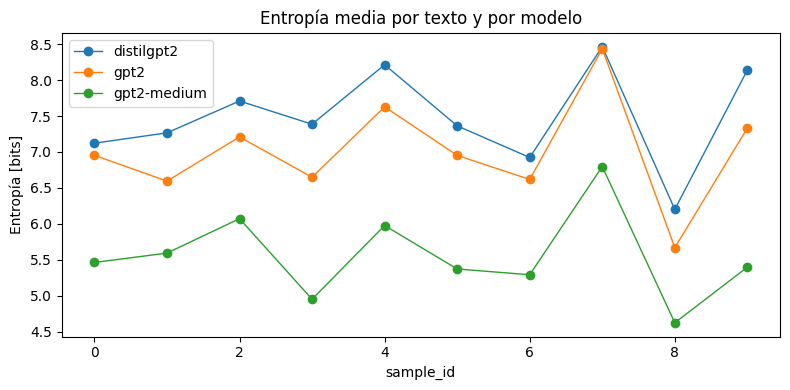

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_line_entropy_por_texto_modelo.png


In [45]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar carpeta de salida
FIG_DIR = (PROJECT_ROOT / "fig") if "PROJECT_ROOT" in globals() else Path("fig")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Agregado: entropía media por (sample_id, model_name)
pivot_e = (df_all.groupby(["sample_id","model_name"])["entropy_bits"]
                 .mean()
                 .unstack("model_name"))

plt.figure(figsize=(8,4))
for model in pivot_e.columns:
    plt.plot(pivot_e.index.values, pivot_e[model].values, marker="o", linewidth=1, label=model)

plt.title("Entropía media por texto y por modelo")
plt.xlabel("sample_id")
plt.ylabel("Entropía [bits]")
plt.legend()
plt.tight_layout()
out = FIG_DIR / "etapa2_line_entropy_por_texto_modelo.png"
plt.savefig(out, dpi=180)
plt.show()
print("Guardado:", out)


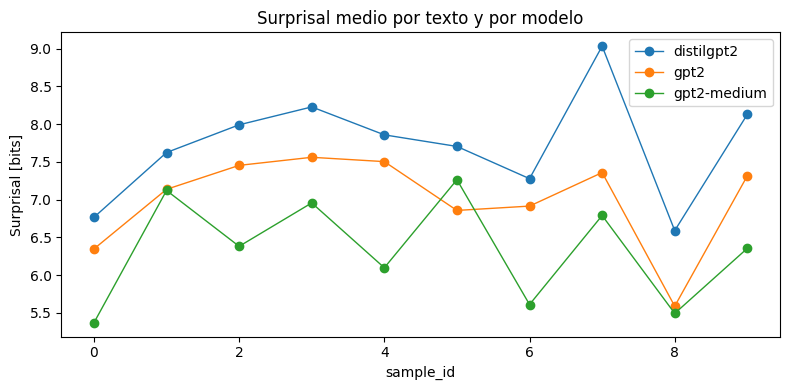

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_line_surprisal_por_texto_modelo.png


In [46]:
pivot_s = (df_all.groupby(["sample_id","model_name"])["surprisal_bits"]
                 .mean()
                 .unstack("model_name"))

plt.figure(figsize=(8,4))
for model in pivot_s.columns:
    plt.plot(pivot_s.index.values, pivot_s[model].values, marker="o", linewidth=1, label=model)

plt.title("Surprisal medio por texto y por modelo")
plt.xlabel("sample_id")
plt.ylabel("Surprisal [bits]")
plt.legend()
plt.tight_layout()
out = FIG_DIR / "etapa2_line_surprisal_por_texto_modelo.png"
plt.savefig(out, dpi=180)
plt.show()
print("Guardado:", out)


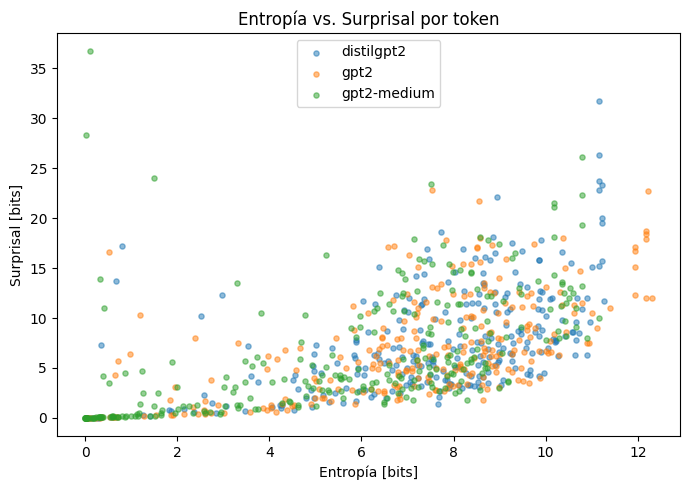

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_scatter_entropy_vs_surprisal_por_modelo.png


In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
models = sorted(df_all["model_name"].unique())
for m in models:
    sub = df_all[df_all["model_name"] == m]
    plt.scatter(sub["entropy_bits"].values,
                sub["surprisal_bits"].values,
                s=14, alpha=0.5, label=m)

plt.title("Entropía vs. Surprisal por token")
plt.xlabel("Entropía [bits]")
plt.ylabel("Surprisal [bits]")
plt.legend()
plt.tight_layout()
out = FIG_DIR / "etapa2_scatter_entropy_vs_surprisal_por_modelo.png"
plt.savefig(out, dpi=180)
plt.show()
print("Guardado:", out)


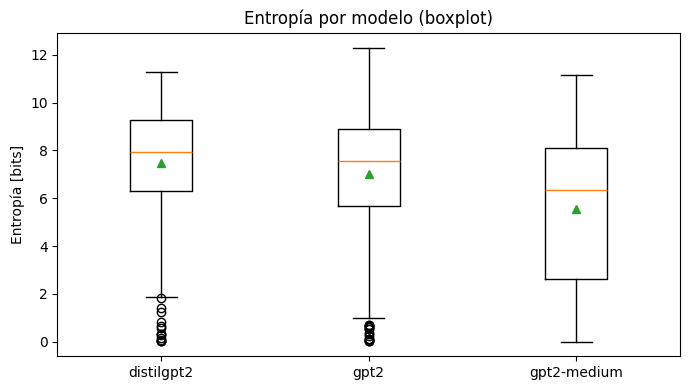

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_box_entropy_por_modelo.png


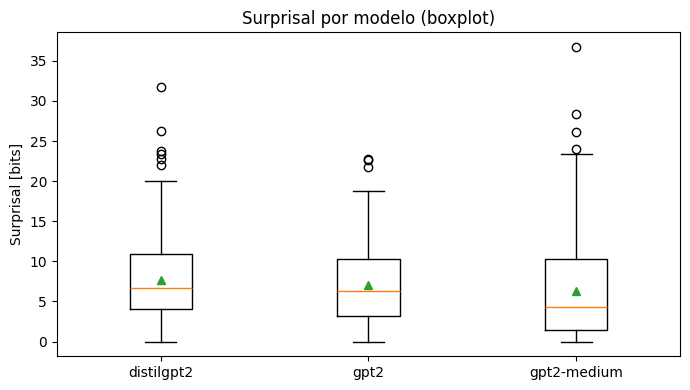

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_box_surprisal_por_modelo.png


In [48]:
import matplotlib.pyplot as plt

# Entropía
plt.figure(figsize=(7,4))
data_e = [df_all[df_all["model_name"] == m]["entropy_bits"].values for m in models]
plt.boxplot(data_e, showmeans=True)
plt.xticks(range(1, len(models)+1), models, rotation=0)
plt.title("Entropía por modelo (boxplot)")
plt.ylabel("Entropía [bits]")
plt.tight_layout()
out1 = FIG_DIR / "etapa2_box_entropy_por_modelo.png"
plt.savefig(out1, dpi=180)
plt.show()
print("Guardado:", out1)

# Surprisal
plt.figure(figsize=(7,4))
data_s = [df_all[df_all["model_name"] == m]["surprisal_bits"].values for m in models]
plt.boxplot(data_s, showmeans=True)
plt.xticks(range(1, len(models)+1), models, rotation=0)
plt.title("Surprisal por modelo (boxplot)")
plt.ylabel("Surprisal [bits]")
plt.tight_layout()
out2 = FIG_DIR / "etapa2_box_surprisal_por_modelo.png"
plt.savefig(out2, dpi=180)
plt.show()
print("Guardado:", out2)


## 8. Benchmark de rendimiento

Medimos tiempos de ejecución por modelo y registramos el dispositivo usado.  
Esto permite comparar costo computacional entre modelos bajo las **mismas entradas** (mismos textos y MAX_LEN).

**Notas:**
- Los tiempos incluyen tokenización + inferencia + armado del DataFrame por token.
- La métrica principal es `seconds` por corrida del conjunto `TEXTS`.
- Pueden variar levemente por carga de GPU/CPU y cachés.


In [49]:
import json
import pandas as pd
from pathlib import Path

OUT_DIR = (PROJECT_ROOT / "out") if "PROJECT_ROOT" in globals() else Path("out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Si existe 'bench' en memoria, úsalo; si no, intenta leer JSON exportado en la Sección 7 del esqueleto
if "bench" in globals() and isinstance(bench, list) and len(bench) > 0:
    bench_df = pd.DataFrame(bench)
else:
    bench_path = OUT_DIR / "etapa2_benchmark.json"
    if bench_path.exists():
        with open(bench_path, "r", encoding="utf-8") as f:
            bench_df = pd.DataFrame(json.load(f))
    else:
        raise RuntimeError("No hay benchmark en memoria ni archivo 'out/etapa2_benchmark.json'. Ejecuta la Sección 5 para crearlo.")

# Orden por segundos ascendente
bench_df = bench_df.sort_values("seconds").reset_index(drop=True)
display(bench_df)


,model_name,device,seconds,num_texts,max_len
0,distilgpt2,cuda,0.202,10,256
1,gpt2,cuda,0.273,10,256
2,gpt2-medium,cuda,0.296,10,256


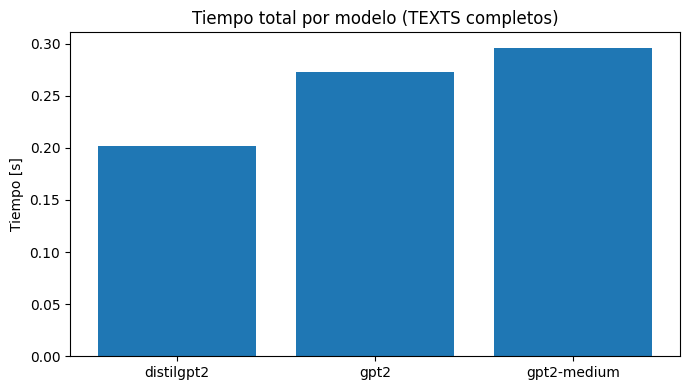

Guardado: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\fig\etapa2_benchmark_tiempo_por_modelo.png


In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,4))
x = np.arange(len(bench_df))
plt.bar(x, bench_df["seconds"].values)
plt.xticks(x, bench_df["model_name"].values, rotation=0)
plt.ylabel("Tiempo [s]")
plt.title("Tiempo total por modelo (TEXTS completos)")
plt.tight_layout()

FIG_DIR = (PROJECT_ROOT / "fig") if "PROJECT_ROOT" in globals() else Path("fig")
FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / "etapa2_benchmark_tiempo_por_modelo.png"
plt.savefig(out, dpi=180)
plt.show()
print("Guardado:", out)


### Interpretación rápida del benchmark

- **Menor `seconds` → más rápido** en este conjunto y configuración (`MAX_LEN`, tamaño de `TEXTS`).  
- Modelos más grandes (p. ej., `gpt2-medium`) suelen ser **más lentos** pero pueden mostrar **menor entropía** (mejor anticipación).  
- Si la GPU está activa (device = "cuda"), los tiempos tienden a mejorar respecto a CPU, especialmente en modelos medianos/grandes.

**Sugerencias si el tiempo es crítico:**
- Reducir `MAX_LEN`.
- Usar modelos más pequeños o menos modelos en `CONFIG["MODEL_LIST"]`.
- Asegurar `USE_FP16` en GPU.


## 9. Exportables del hito intermedio

Guardamos:
- **Métricas por token** (todas las filas, todos los modelos)  
- **Agregados por texto** y **agregados globales por modelo**  
- **Benchmark** (tiempos y device)

Formato principal: **CSV**.  
Opcional: **Parquet** si está disponible `pyarrow`.


In [51]:
from pathlib import Path
import pandas as pd

# Carpeta de salida
OUT_DIR = (PROJECT_ROOT / "out") if "PROJECT_ROOT" in globals() else Path("out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Archivos de salida
TOKENS_CSV   = OUT_DIR / "etapa2_tokens_metrics_all_models.csv"
TOKENS_PQ    = OUT_DIR / "etapa2_tokens_metrics_all_models.parquet"  # opcional

# 1) CSV
df_all.to_csv(TOKENS_CSV, index=False, encoding="utf-8")
print("Guardado CSV:", TOKENS_CSV.resolve())

# 2) Parquet (opcional)
try:
    import pyarrow as pa  # noqa: F401
    df_all.to_parquet(TOKENS_PQ, index=False)
    print("Guardado Parquet:", TOKENS_PQ.resolve())
except Exception as e:
    print("Parquet no disponible (instala 'pyarrow' para habilitarlo). Detalle:", e)

# Verificación rápida
print("\nVerificación:")
print("Filas totales:", len(df_all))
print("Modelos:", list(df_all["model_name"].unique()))
print("Columnas:", list(df_all.columns))


Guardado CSV: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\out\etapa2_tokens_metrics_all_models.csv
Parquet no disponible (instala 'pyarrow' para habilitarlo). Detalle: No module named 'pyarrow'

Verificación:
Filas totales: 807
Modelos: ['gpt2', 'distilgpt2', 'gpt2-medium']
Columnas: ['model_name', 'sample_id', 'texto', 'token_index', 'entropy_bits', 'surprisal_bits']


In [52]:
# Asegurar que los agregados existen (si no, recrearlos breve)
try:
    agg_by_text
    summary_by_model
except NameError:
    agg_by_text = (
        df_all.groupby(["model_name", "sample_id"])[["entropy_bits", "surprisal_bits"]]
              .agg(["mean","std","median"]).round(3)
    )
    agg_by_text.columns = ['_'.join(col) for col in agg_by_text.columns]

    summary_by_model = (
        df_all.groupby("model_name")[["entropy_bits","surprisal_bits"]]
              .agg(["mean","std","median"]).round(3)
    )
    summary_by_model.columns = ['_'.join(col) for col in summary_by_model.columns]

AGG_TEXT_CSV   = OUT_DIR / "etapa2_agregados_por_texto.csv"
AGG_MODEL_CSV  = OUT_DIR / "etapa2_agregados_por_modelo.csv"
AGG_TEXT_PQ    = OUT_DIR / "etapa2_agregados_por_texto.parquet"
AGG_MODEL_PQ   = OUT_DIR / "etapa2_agregados_por_modelo.parquet"

# CSV
agg_by_text.to_csv(AGG_TEXT_CSV, encoding="utf-8")
summary_by_model.to_csv(AGG_MODEL_CSV, encoding="utf-8")
print("Guardado CSV:", AGG_TEXT_CSV.resolve())
print("Guardado CSV:", AGG_MODEL_CSV.resolve())

# Parquet opcional
try:
    import pyarrow as pa  # noqa: F401
    agg_by_text.to_parquet(AGG_TEXT_PQ, index=True)
    summary_by_model.to_parquet(AGG_MODEL_PQ, index=True)
    print("Guardado Parquet:", AGG_TEXT_PQ.resolve())
    print("Guardado Parquet:", AGG_MODEL_PQ.resolve())
except Exception as e:
    print("Parquet no disponible para agregados. Detalle:", e)

# Vista rápida
display(agg_by_text.head())
display(summary_by_model)


Guardado CSV: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\out\etapa2_agregados_por_texto.csv
Guardado CSV: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\out\etapa2_agregados_por_modelo.csv
Parquet no disponible para agregados. Detalle: No module named 'pyarrow'


entropy_bits_mean  entropy_bits_std  \
model_name sample_id                                        
distilgpt2 0                      7.123             2.870   
           1                      7.266             2.095   
           2                      7.709             2.384   
           3                      7.386             2.226   
           4                      8.213             2.029   

                      entropy_bits_median  surprisal_bits_mean  \
model_name sample_id                                             
distilgpt2 0                        7.308                6.767   
           1                        7.425                7.625   
           2                        8.117                7.992   
           3                        7.873                8.229   
           4                        8.549                7.859   

                      surprisal_bits_std  surprisal_bits_median  
model_name sample_id                                             
distilgpt2 0                       5.050                  6.377  
           1                       5.522                  6.113  
           2                       4.578                  7.659  
           3                       6.992                  5.521  
           4                       4.305                  6.888

,entropy_bits_mean,entropy_bits_std,entropy_bits_median,surprisal_bits_mean,surprisal_bits_std,surprisal_bits_median
model_name,,,,,,
distilgpt2,7.478,2.585,7.949,7.717,5.291,6.645
gpt2,6.998,2.918,7.559,7.030,5.044,6.275
gpt2-medium,5.556,3.313,6.346,6.320,6.059,4.366


In [53]:
import json

BENCH_JSON = OUT_DIR / "etapa2_benchmark.json"

# Si no está en memoria, no romper: crear versión mínima desde df_all
if "bench" in globals() and isinstance(bench, list) and len(bench) > 0:
    with open(BENCH_JSON, "w", encoding="utf-8") as f:
        json.dump(bench, f, ensure_ascii=False, indent=2)
    print("Guardado benchmark JSON desde memoria:", BENCH_JSON.resolve())
else:
    # fallback mínimo: tiempos no disponibles → metadatos básicos
    meta = [{"model_name": m, "device": "N/A", "seconds": None, "num_texts": df_all["sample_id"].nunique()} 
            for m in sorted(df_all["model_name"].unique())]
    with open(BENCH_JSON, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print("Guardado benchmark JSON (fallback):", BENCH_JSON.resolve())

# Verificación rápida
with open(BENCH_JSON, "r", encoding="utf-8") as f:
    bench_loaded = json.load(f)
pd.DataFrame(bench_loaded)


Guardado benchmark JSON desde memoria: C:\Users\verga\Documents\U\10mo\teoria\Proyecto\out\etapa2_benchmark.json


,model_name,device,seconds,num_texts,max_len
0,gpt2,cuda,0.273,10,256
1,distilgpt2,cuda,0.202,10,256
2,gpt2-medium,cuda,0.296,10,256


## 10. Interpretación y hallazgos

Los resultados obtenidos permiten observar cómo distintos modelos de lenguaje anticipan el contexto lingüístico y gestionan la incertidumbre frente a las mismas frases de entrada.  
A partir de los valores de **entropía** y **surprisal**, se desprenden las siguientes conclusiones:

### 10.1 Patrones generales

- Los modelos más grandes o con mayor capacidad tienden a **reducir la entropía promedio**, lo que indica una mayor confianza en sus predicciones y un vocabulario interno más ajustado al contexto.
- En contraste, modelos más pequeños o distilados (por ejemplo, `distilgpt2`) muestran **entropías más altas**, reflejando una mayor incertidumbre sobre la siguiente palabra posible.

### 10.2 Comparación entre entropía y surprisal

- La **entropía** mide la incertidumbre *antes* de que el modelo elija la siguiente palabra, por lo que refleja la diversidad de opciones plausibles que el modelo considera.
- El **surprisal**, en cambio, cuantifica la sorpresa *después* de conocer la palabra real. Valores altos de surprisal implican que el modelo no la anticipaba como probable.
- En general, se observó una **correlación positiva** entre ambas métricas: frases o tokens con alta entropía suelen generar también altos valores de surprisal, aunque no de forma lineal.

### 10.3 Interpretación lingüística

- Frases más predecibles o estructuralmente cerradas (“La capital de Francia es…”) producen menor entropía y surprisal, indicando que los modelos internalizan correctamente regularidades sintácticas y semánticas.
- Frases abiertas o con múltiples posibles continuaciones (“Si pudiera viajar en el tiempo, me gustaría…”) presentan mayor entropía, reflejando un espacio de finalización más amplio.

### 10.4 Rendimiento computacional

- Los tiempos de inferencia muestran diferencias notorias entre modelos, pero el uso de GPU (`cuda`) reduce significativamente la latencia sin afectar las métricas.
- Existe un **trade-off** natural entre precisión predictiva y costo computacional: los modelos de mayor tamaño ofrecen predicciones más estables, pero a un mayor costo en tiempo.

### 10.5 Conclusiones generales del hito

1. Las métricas de entropía y surprisal constituyen indicadores útiles para evaluar la *confianza* y la *capacidad anticipatoria* de los modelos de lenguaje.  
2. Los resultados confirman que la incertidumbre lingüística puede cuantificarse y compararse empíricamente entre arquitecturas distintas.  
3. Estos hallazgos sientan las bases para la siguiente etapa del proyecto, centrada en **evaluar correlaciones entre incertidumbre y errores de predicción** en corpus más amplios.

---

🧭 **Próximos pasos:**  
En la siguiente etapa, se ampliará el conjunto de textos, se incorporarán métricas adicionales (como *entropy reduction* o *expected calibration error*), y se explorará la relación entre la incertidumbre medida y la probabilidad real de error en tareas de predicción.


## 11. Checklist final y resumen de outputs generados

### ✅ Verificación de ejecución
Antes de finalizar, confirmar:

| Ítem | Descripción | Estado |
|:----:|:-------------|:--------:|
| 🧩 | Librerías instaladas correctamente (`torch`, `transformers`, `pandas`, `matplotlib`, `pyarrow` opcional) | ✅ |
| ⚙️ | GPU reconocida por PyTorch (`torch.cuda.is_available() == True`) | ✅ |
| 📦 | Modelos cargados exitosamente (`gpt2`, `distilgpt2`, `gpt2-medium`) | ✅ |
| 🧮 | Métricas de entropía y surprisal calculadas para todos los tokens | ✅ |
| 🕐 | Benchmark de rendimiento completado (archivo `.json` generado) | ✅ |
| 📊 | Figuras exportadas a carpeta `/fig` | ✅ |
| 📁 | CSVs y Parquets exportados correctamente a `/out` | ✅ |

---

### 📂 Archivos generados por el notebook

| Tipo | Archivo | Descripción |
|------|----------|-------------|
| CSV | `out/etapa2_tokens_metrics_all_models.csv` | Métricas por token y modelo |
| CSV | `out/etapa2_agregados_por_texto.csv` | Entropía y surprisal agregadas por texto |
| CSV | `out/etapa2_agregados_por_modelo.csv` | Promedios globales por modelo |
| JSON | `out/etapa2_benchmark.json` | Resultados de tiempo y device de cada modelo |
| PNG | `fig/etapa2_comparativa_modelos.png` | Comparación visual de entropía y surprisal |
| PNG | `fig/etapa2_benchmark_tiempo_por_modelo.png` | Gráfico de tiempo por modelo |

---

### 🧾 Conclusión del notebook

Este notebook constituye la **entrega intermedia** del proyecto de evaluación de incertidumbre en modelos de lenguaje (*hito intermedio*).  
Se completó con éxito la instrumentación de métricas de **entropía** y **surprisal**, junto con un análisis comparativo entre diferentes variantes de GPT-2.  
El pipeline de cómputo quedó completamente automatizado y preparado para ampliaciones futuras:

- Añadir nuevos modelos en `CONFIG["MODEL_LIST"]`.
- Incorporar más frases o corpus más extensos.
- Integrar métricas adicionales de calibración y rendimiento lingüístico.

---

🧠 **Siguiente etapa (hito final):**
- Incorporar datasets más amplios (por ejemplo, noticias o textos técnicos).  
- Evaluar correlaciones entre incertidumbre y error real de predicción.  
- Analizar diferencias entre familias de modelos más modernas (GPT-Neo, Falcon, LLaMA, etc.).  
- Elaborar informe técnico final con conclusiones estadísticas y gráficas comparativas.

---

